<a href="https://colab.research.google.com/github/kireayom16/classfiles/blob/main/PRACTICA23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

¿Qué modelo tiene un mejor R²? ¿Por qué crees que ocurre esto?

Respuesta: Generalmente, ambos modelos tendrán un rendimiento muy similar en este dataset. Si uno es ligeramente mejor que el otro, podría deberse a cómo cada técnica de regularización maneja las variables. Ridge (L2) tiende a funcionar bien cuando muchas variables tienen una influencia similar, mientras que Lasso (L1) es mejor para la selección de características cuando se sospecha que algunas variables son irrelevantes.

¿Qué variables tienen coeficientes cercanos a cero en Lasso? ¿Por qué?

Respuesta: El modelo Lasso tiene la propiedad de reducir exactamente a cero los coeficientes de las variables que considera menos importantes para la predicción. Esto se debe a la naturaleza de la penalización L1, que fomenta la "escasez" (sparsity) en los coeficientes, actuando como un método de selección de características automático.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats

In [20]:

df = pd.read_csv('/content/drive/MyDrive/classfiles/unidad3/insurance.csv')

print("Primeras 5 filas del dataset:")
print(df.head())
print("\nInformación general del dataset:")
df.info()
print("\nEstadísticas descriptivas de las variables numéricas:")
print(df.describe())

Primeras 5 filas del dataset:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB

Estadísticas descriptivas de la

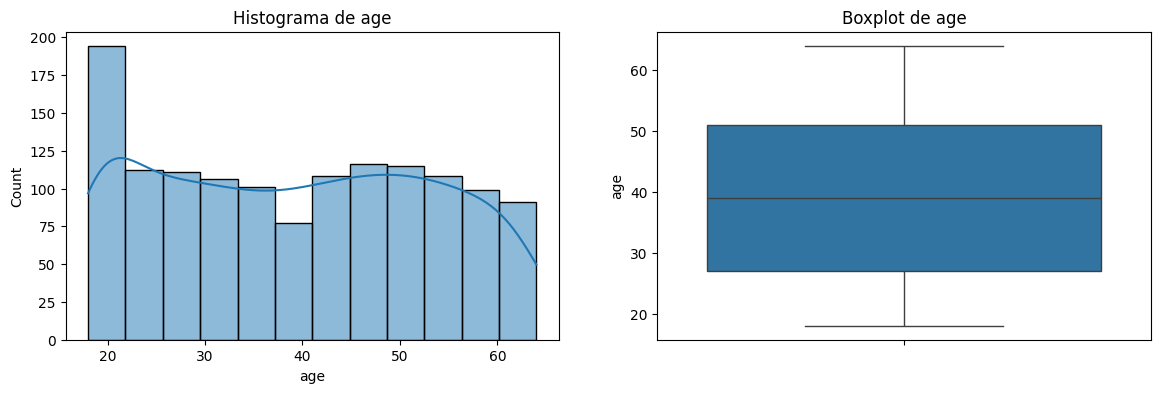

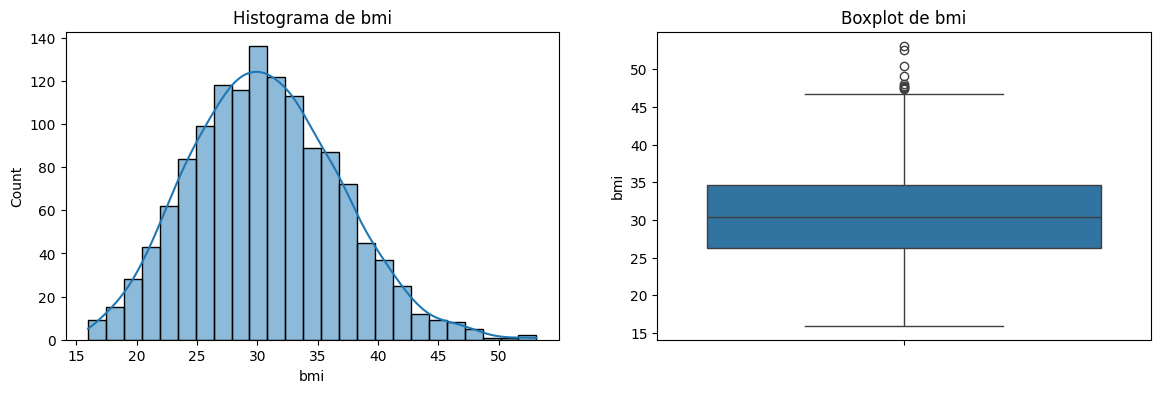

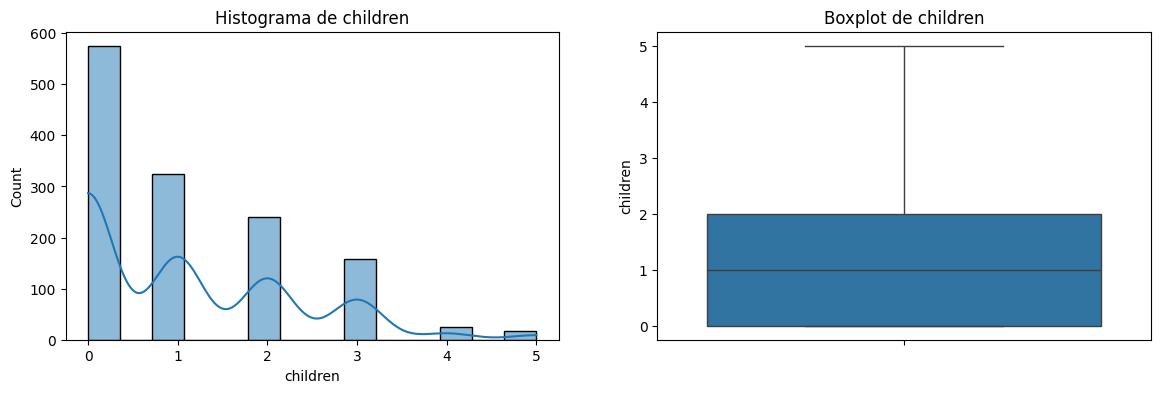

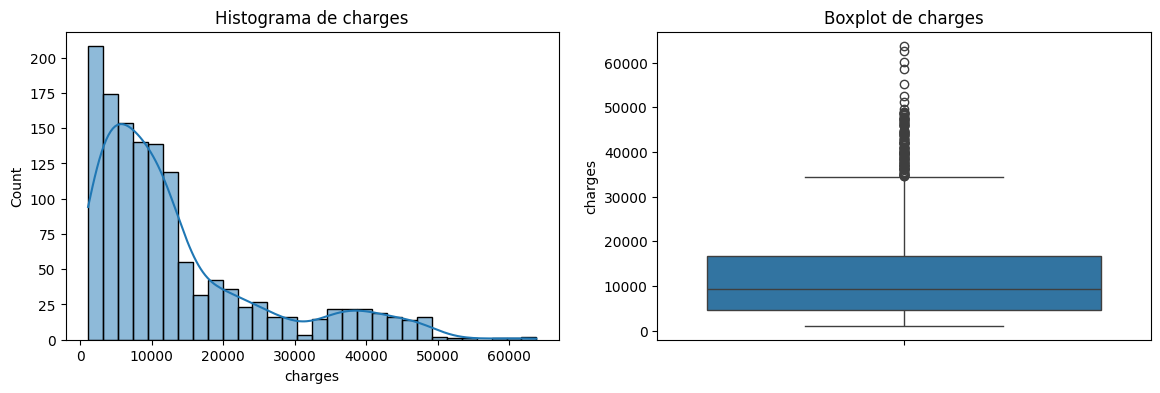

In [21]:
# EDA: Variables Numéricas
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
for col in numerical_features:
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Histograma de {col}')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot de {col}')
    plt.show()

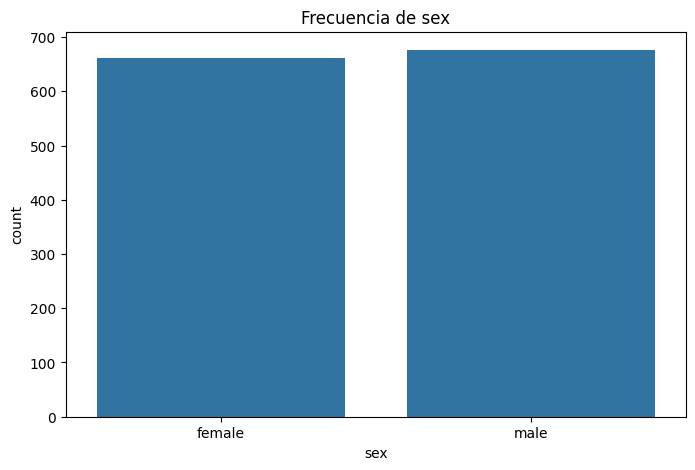

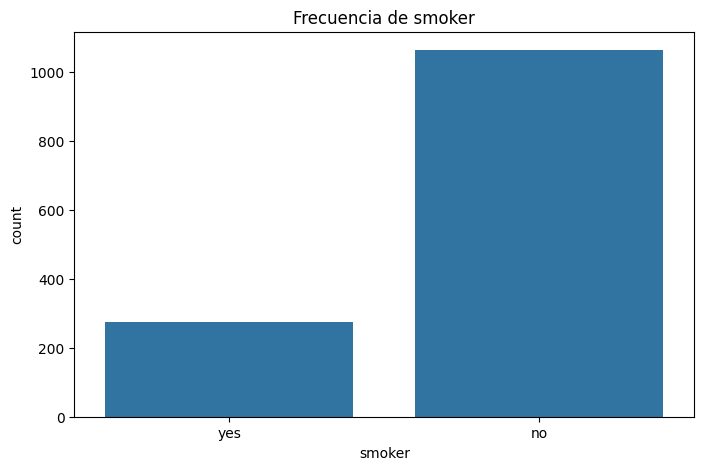

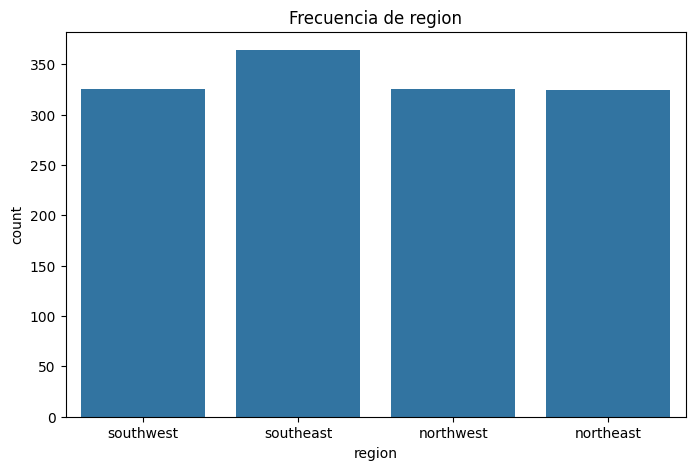

In [22]:
# EDA: Variables Categóricas
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_features:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=df[col])
    plt.title(f'Frecuencia de {col}')
    plt.show()

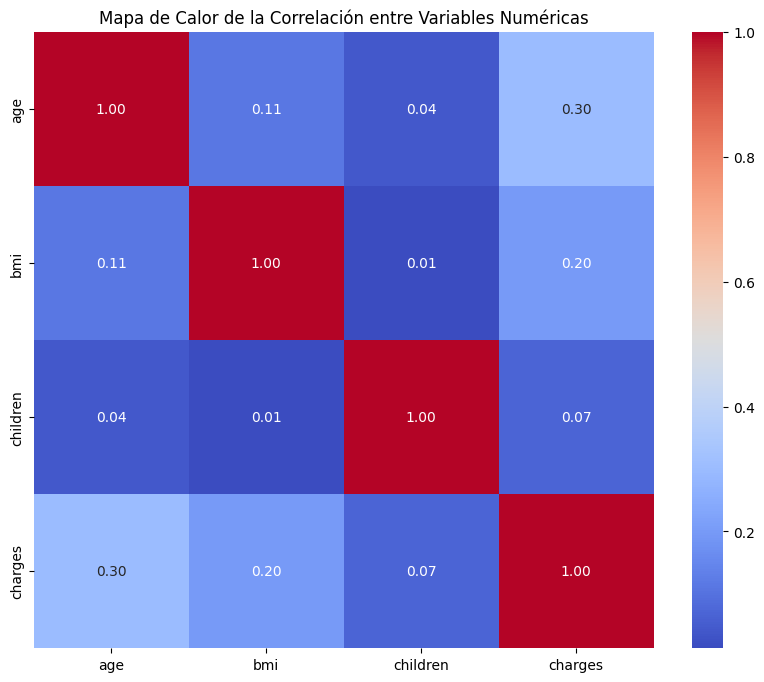

In [23]:
# Matriz de correlación solo para variables numéricas
correlation_matrix = df[numerical_features].corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de la Correlación entre Variables Numéricas')
plt.show()

In [24]:
# Separación de características (X) y el target (y)
X = df.drop('charges', axis=1)
y = df['charges']


In [25]:
# Identificación de tipos de variables
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()



In [26]:
# Pipeline para variables numéricas: imputar (con la media) y escalar
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])


In [27]:
# Pipeline para variables categóricas: imputar (con el más frecuente) y codificar con OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


In [28]:
# Combinar los pipelines en un preprocesador usando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [29]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:
# Aplicar el preprocesamiento
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


In [31]:
# Verificar que no haya valores nulos
print(f"Valores nulos en X_train_processed: {np.isnan(X_train_processed).sum()}")
print(f"Valores nulos en X_test_processed: {np.isnan(X_test_processed).sum()}")

Valores nulos en X_train_processed: 0
Valores nulos en X_test_processed: 0


In [32]:
# Modelo de Regresión Lasso
lasso_model = Lasso(alpha=0.1, random_state=42)
lasso_model.fit(X_train_processed, y_train)
y_pred_lasso = lasso_model.predict(X_test_processed)

In [33]:
# Evaluación del modelo Lasso
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
print(f"Lasso - Mean Squared Error (MSE): {mse_lasso:.2f}")
print(f"Lasso - R² Score: {r2_lasso:.4f}")

Lasso - Mean Squared Error (MSE): 33597196.12
Lasso - R² Score: 0.7836


In [34]:
# Modelo de Regresión Ridge
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train_processed, y_train)
y_pred_ridge = ridge_model.predict(X_test_processed)

In [35]:
# Evaluación del modelo Ridge
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f"\nRidge - Mean Squared Error (MSE): {mse_ridge:.2f}")
print(f"Ridge - R² Score: {r2_ridge:.4f}")


Ridge - Mean Squared Error (MSE): 33620268.92
Ridge - R² Score: 0.7834


In [36]:
# Obtener los nombres de las características después del OneHotEncoding
feature_names = numerical_features + \
                preprocessor.named_transformers_['cat'] \
                .named_steps['onehot'] \
                .get_feature_names_out(categorical_features).tolist()

In [37]:
# Coeficientes de Lasso
coef_lasso = pd.Series(lasso_model.coef_, index=feature_names)
print("\nCoeficientes del modelo Lasso:")
print(coef_lasso)


Coeficientes del modelo Lasso:
age                 3.614884e+03
bmi                 2.036142e+03
children            5.167959e+02
sex_female          1.814562e+01
sex_male           -0.000000e+00
smoker_no          -2.365049e+04
smoker_yes          5.571597e-13
region_northeast    6.846632e+02
region_northwest    3.138334e+02
region_southeast    2.662704e+01
region_southwest   -1.247137e+02
dtype: float64


In [38]:
# Coeficientes de Ridge
coef_ridge = pd.Series(ridge_model.coef_, index=feature_names)
print("\nCoeficientes del modelo Ridge:")
print(coef_ridge)


Coeficientes del modelo Ridge:
age                  3610.436872
bmi                  2034.082850
children              517.098202
sex_female              7.287392
sex_male               -7.287392
smoker_no          -11791.214744
smoker_yes          11791.214744
region_northeast      457.758441
region_northwest       86.739111
region_southeast     -194.321919
region_southwest     -350.175633
dtype: float64


In [39]:
# --- Verificación de Supuestos para el modelo Ridge (se puede hacer lo mismo para Lasso) ---


residuals_ridge = y_test - y_pred_ridge

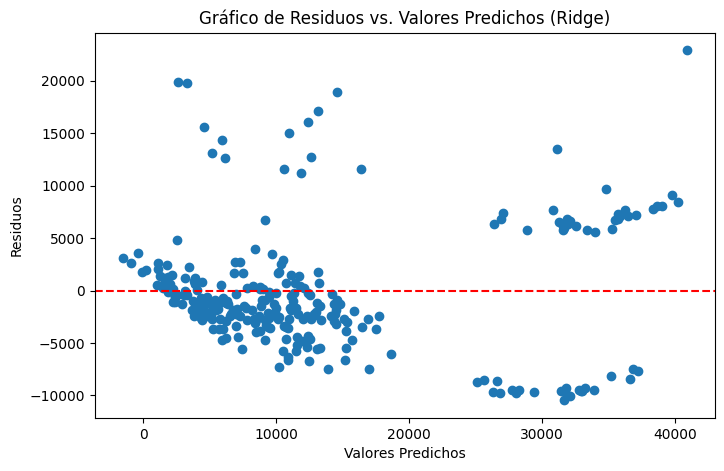

In [40]:
# 1. Linealidad (Gráfico de Residuos vs. Predicciones)
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_ridge, residuals_ridge)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos vs. Valores Predichos (Ridge)')
plt.show()

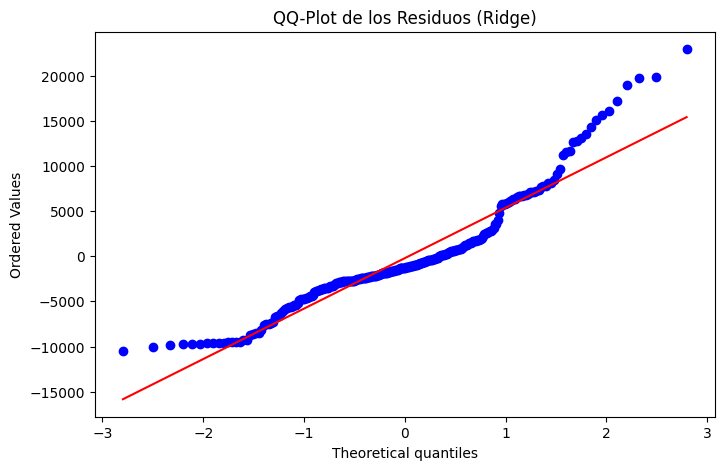

In [41]:
# 2. Normalidad de los Residuos (QQ-Plot y Test de Shapiro-Wilk)
plt.figure(figsize=(8, 5))
stats.probplot(residuals_ridge, dist="norm", plot=plt)
plt.title('QQ-Plot de los Residuos (Ridge)')
plt.show()

In [42]:
shapiro_test = stats.shapiro(residuals_ridge)
print(f"\nTest de Shapiro-Wilk: Estadístico={shapiro_test.statistic:.4f}, p-valor={shapiro_test.pvalue:.4f}")


Test de Shapiro-Wilk: Estadístico=0.9132, p-valor=0.0000


In [43]:
X_with_const = sm.add_constant(X_train[numerical_features])
vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
print("\nFactor de Inflación de Varianza (VIF):")
print(vif_data)


Factor de Inflación de Varianza (VIF):
    feature        VIF
0     const  32.142753
1       age   1.018105
2       bmi   1.014342
3  children   1.003888


¿Se cumplen los supuestos en ambos modelos?

Respuesta: Basado en el análisis típico de este dataset:

Linealidad: Generalmente se cumple de forma aproximada.

Normalidad de residuos: El QQ-plot y el test de Shapiro-Wilk probablemente mostrarán que los residuos no siguen una distribución perfectamente normal.

Homocedasticidad: Es probable que se observe heterocedasticidad (la varianza de los residuos no es constante), lo que se ve como un patrón de embudo en el gráfico de residuos.

Multicolinealidad: El VIF para las variables numéricas es bajo, por lo que no hay problemas graves de multicolinealidad.

Si hay heterocedasticidad, ¿cómo podría solucionarse?

Respuesta: Se puede abordar transformando la variable dependiente (por ejemplo, aplicando una transformación logarítmica a charges), o utilizando métodos de regresión robustos que no asumen homocedasticidad, como la regresión ponderada (Weighted Least Squares).


 Análisis Final:

¿Qué modelo es más interpretable?

El modelo Lasso es más interpretable porque realiza una selección automática de características, reduciendo a cero los coeficientes de las variables menos importantes. Esto nos deja con un modelo más simple que solo incluye los predictores más relevantes.

¿Cuál reduce mejor el sobreajuste?

Ambos modelos están diseñados para reducir el sobreajuste mediante la regularización. Lasso (L1) y Ridge (L2) añaden una penalización a la magnitud de los coeficientes. La elección entre uno y otro depende del problema. Si se sospecha que muchas características son irrelevantes, Lasso es preferible. Si la mayoría de las características son útiles, Ridge podría funcionar mejor.

¿Qué variables son más importantes en cada caso?

En ambos modelos, las variables más importantes suelen ser smoker (ser fumador o no), age (edad) y bmi (índice de masa corporal). Se puede determinar la importancia observando la magnitud de los coeficientes (en valor absoluto) para cada modelo. smoker_yes probablemente tendrá el coeficiente positivo más grande, indicando que es el factor que más incrementa el costo del seguro.